In [19]:
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"} # As everything is eager by default in tf 2.0 


import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.compat.v1.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.compat.v1.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.compat.v1.InteractiveSession(config=config)

reset_sess()

In [6]:
# Build Graph
rv_coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5, dtype=tf.int32)

num_trials = tf.constant([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])

coin_flip_data = rv_coin_flip_prior.sample(num_trials[-1])

# prepend a 0 onto tally of heads and tails, for zeroth flip
coin_flip_data = tf.pad(coin_flip_data,tf.constant([[1, 0,]]),"CONSTANT")

# compute cumulative headcounts from 0 to 2000 flips, and then grab them at each of num_trials intervals
cumulative_headcounts = tf.gather(tf.cumsum(coin_flip_data), num_trials)

rv_observed_heads = tfp.distributions.Beta(
    concentration1=tf.cast(1 + cumulative_headcounts, tf.float32),
    concentration0=tf.cast(1 + num_trials - cumulative_headcounts, tf.float32))

probs_of_heads = tf.linspace(start=0., stop=1., num=100, name="linspace")
observed_probs_heads = tf.transpose(rv_observed_heads.prob(probs_of_heads[:, tf.newaxis]))

In [11]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)


In [12]:
# Execute graph
[num_trials_,
probs_of_heads_,
observed_probs_heads_,
cumulative_headcounts_,
] = evaluate([
  num_trials,
  probs_of_heads,
  observed_probs_heads,
  cumulative_headcounts
])



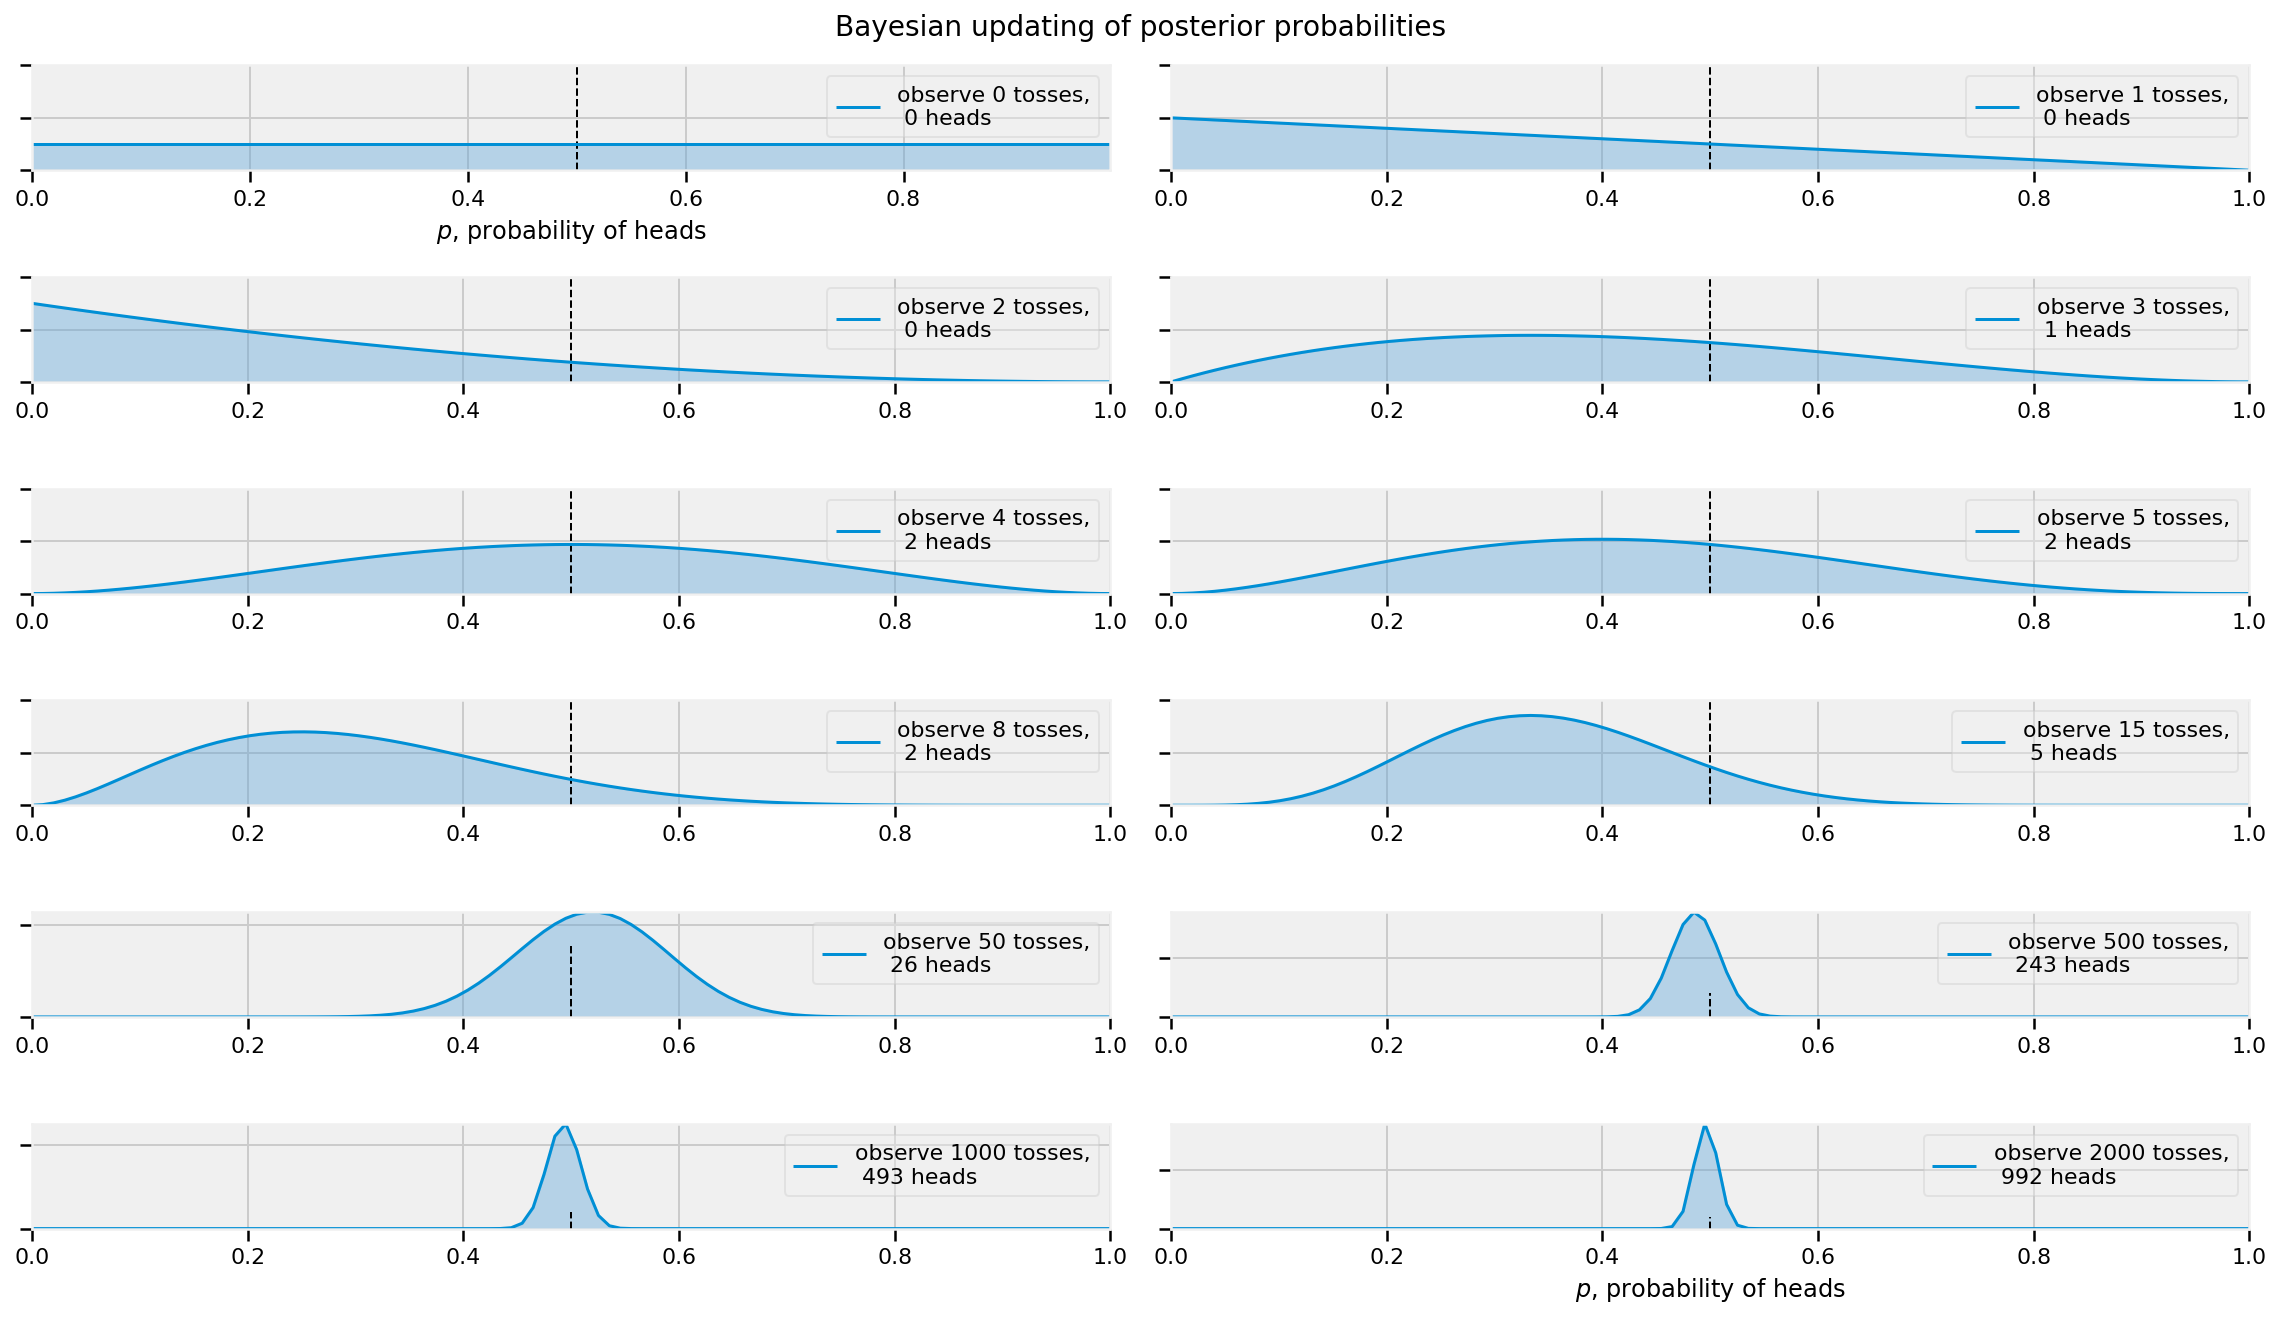

In [13]:
# For the already prepared, I'm using Binomial's conj. prior.
plt.figure(figsize(16, 9))
for i in range(len(num_trials_)):
    sx = plt.subplot(len(num_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (num_trials_[i], cumulative_headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

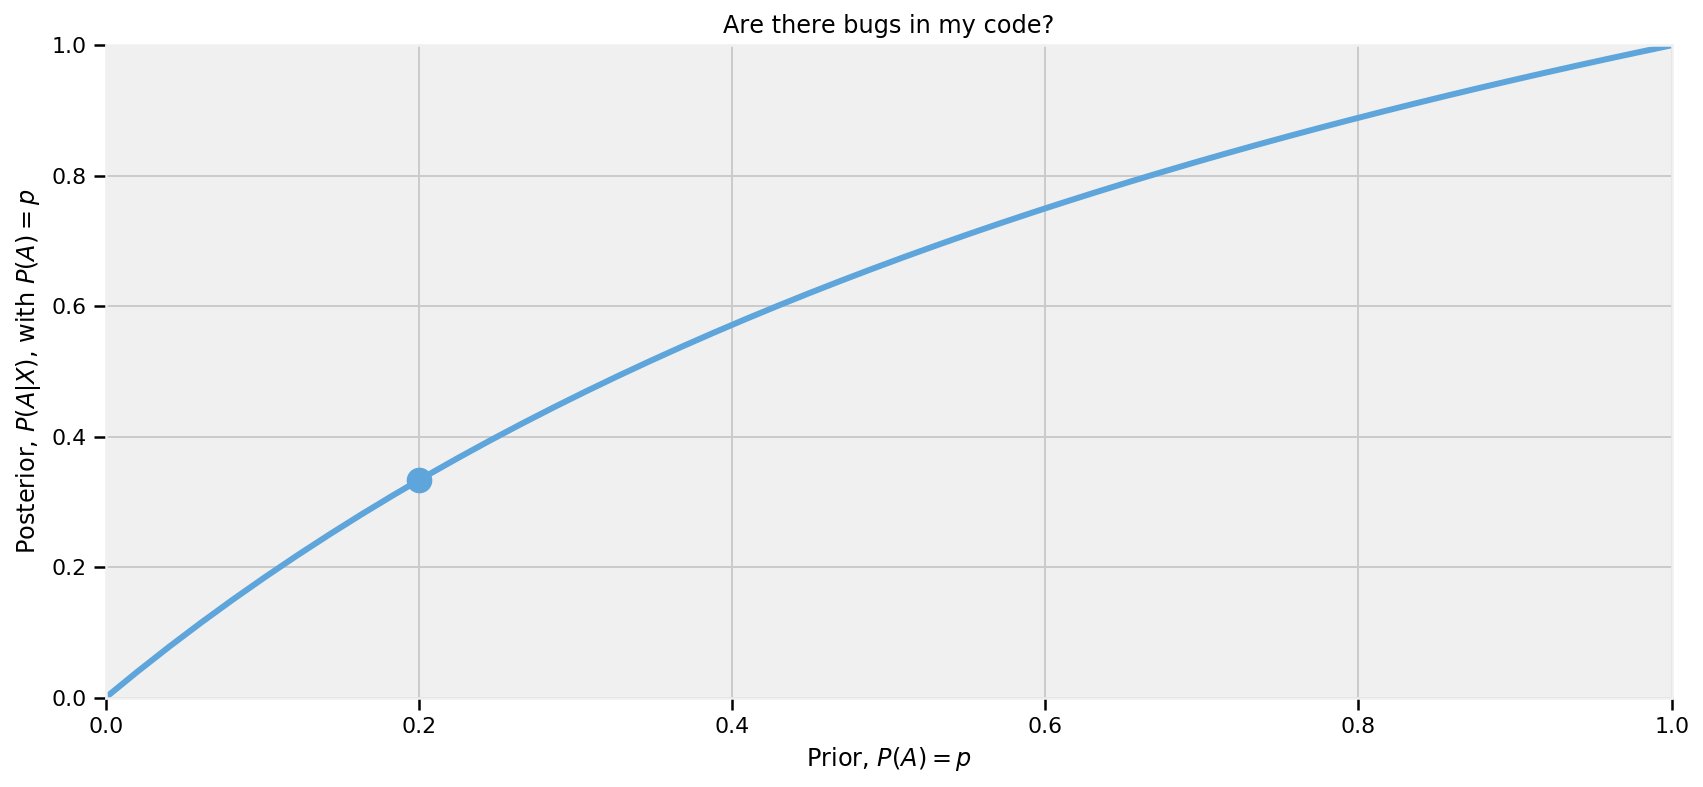

In [14]:


# Defining our range of probabilities
p = tf.linspace(start=0., stop=1., num=50)

# Convert from TF to numpy.
[p_] = evaluate([p])

# Visualization.
plt.figure(figsize=(12.5, 6))
plt.plot(p_, 2*p_/(1+p_), color=TFColor[3], lw=3)
#plt.fill_between(p, 2*p/(1+p), alpha=.5, facecolor=["#A60628"])
plt.scatter(0.2, 2*(0.2)/1.2, s=140, c=TFColor[3])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r"Prior, $P(A) = p$")
plt.ylabel(r"Posterior, $P(A|X)$, with $P(A) = p$")
plt.title(r"Are there bugs in my code?");



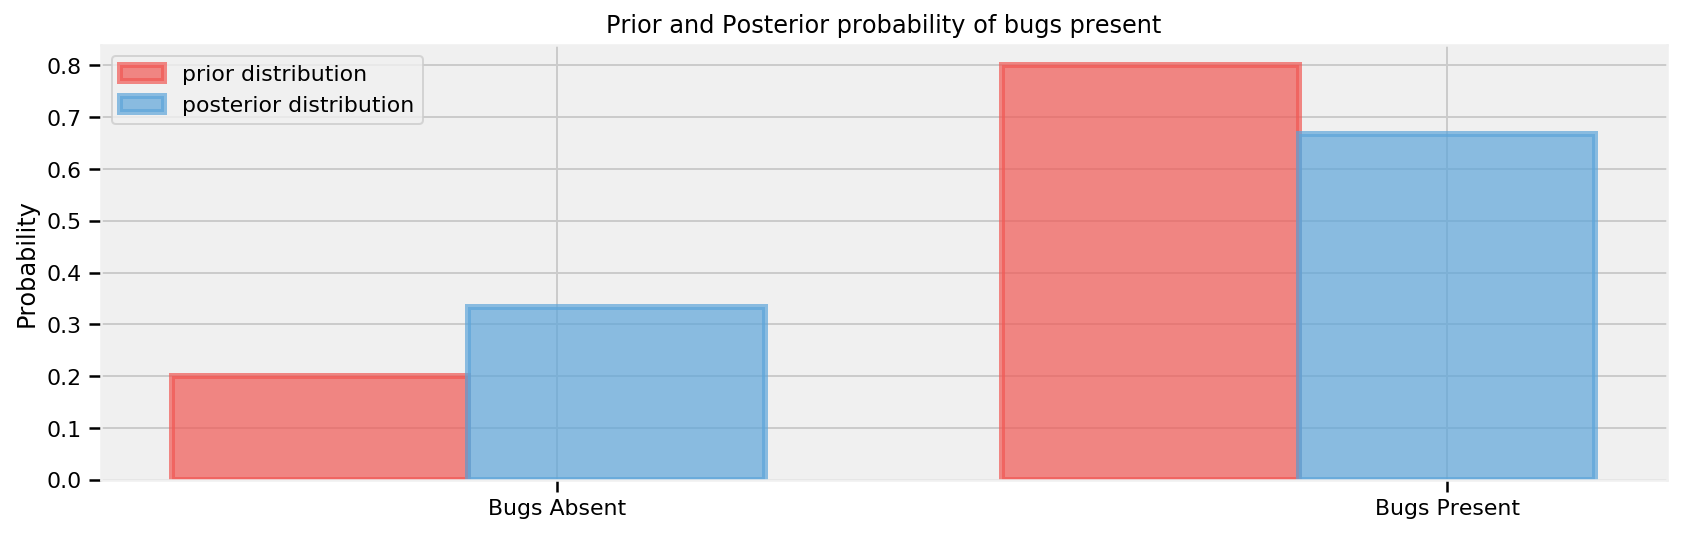

In [15]:


# Defining our priors and posteriors
prior = tf.constant([0.20, 0.80])
posterior = tf.constant([1./3, 2./3])

# Convert from TF to numpy.
[
    prior_,
    posterior_,
] = evaluate([
    prior,
    posterior,
])


# Our Simple Visualization
plt.figure(figsize=(12.5, 4))
colours = [TFColor[0], TFColor[3]]
plt.bar([0, .7], prior_, alpha=0.70, width=0.25,
        color=colours[0], label="prior distribution",
        lw="3", edgecolor=colours[0])
plt.bar([0+0.25, .7+0.25], posterior_, alpha=0.7,
        width=0.25, color=colours[1],
        label=r"posterior distribution",
        lw="3", edgecolor=colours[1])

plt.xticks([0.20, .95], ["Bugs Absent", "Bugs Present"])
plt.title(r"Prior and Posterior probability of bugs present")
plt.ylabel("Probability")
plt.legend(loc="upper left");



W0701 23:38:08.712270 139981438957376 deprecation.py:323] From /home/harshit/workspace/tflow2/lib/python3.7/site-packages/tensorflow_probability/python/distributions/poisson.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


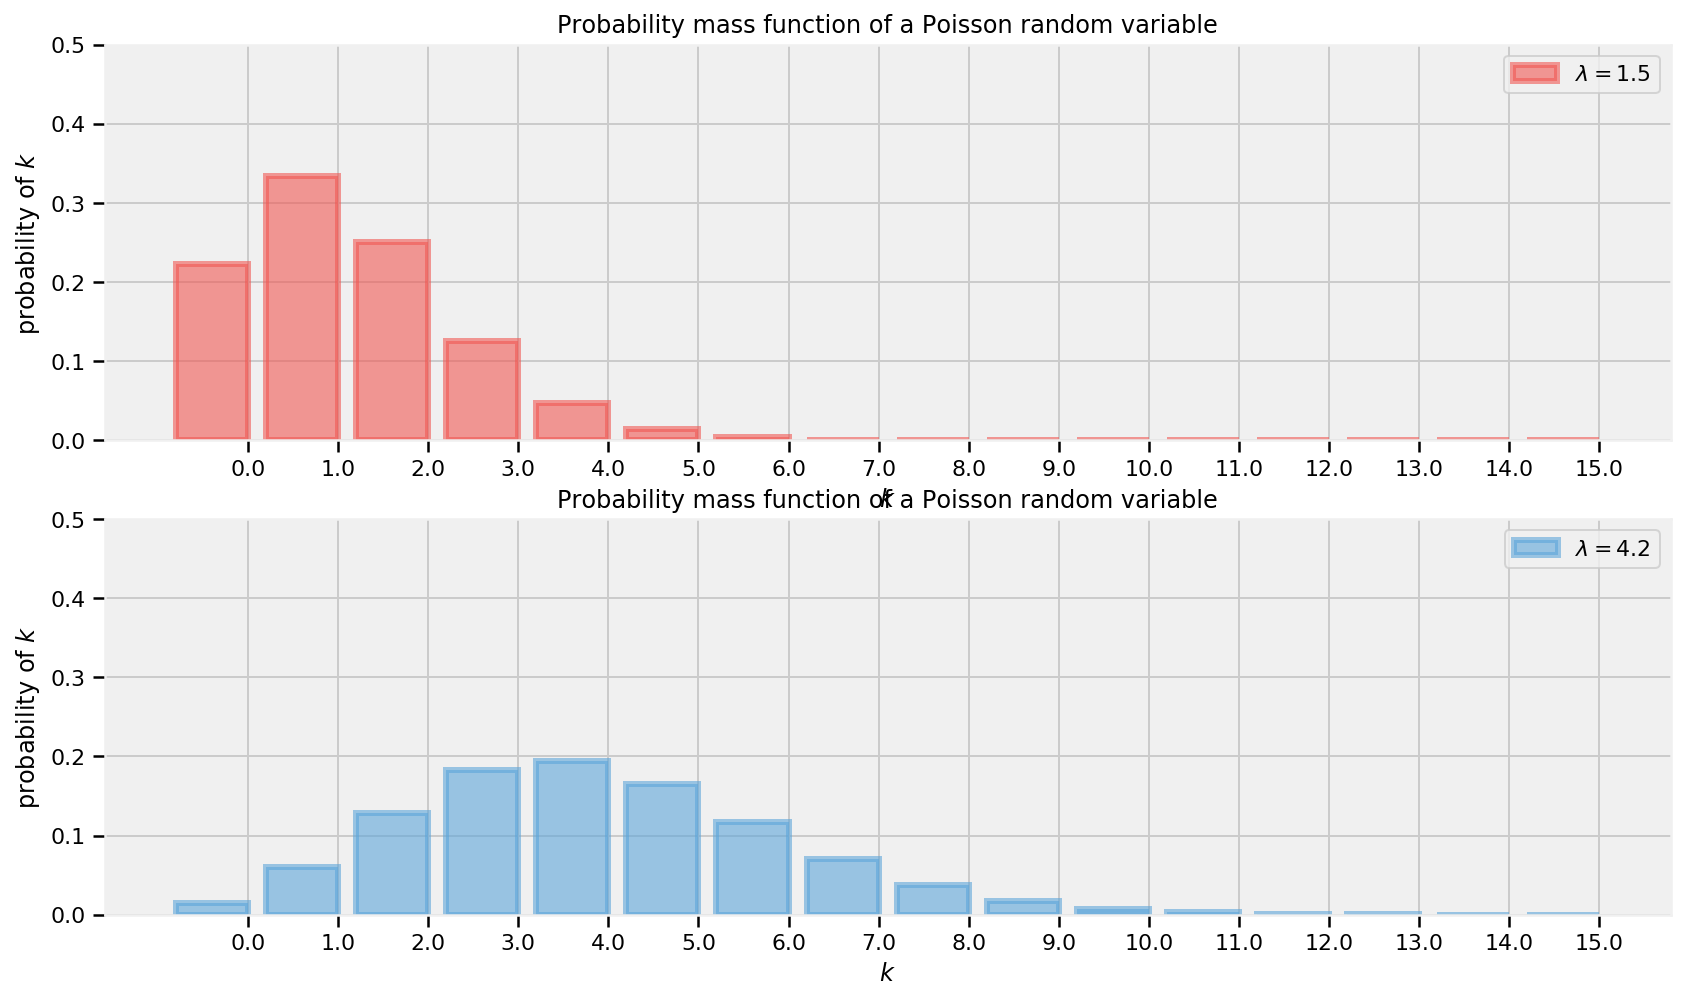

In [16]:
# Build graph.
x = tf.range (start=0., limit=16.)
lambdas = tf.constant([1.5, 4.25])

poi_pmf = tfd.Poisson(
  rate=lambdas[:, tf.newaxis]).prob(x)

# Execute graph
[
  x_,
  lambdas_,
  poi_pmf_,
] = evaluate([
  x,
  lambdas,
  poi_pmf,
])

plt.figure(figsize=(12.5, 8))

# Display results in two different histograms, for easier comparison
colours = [TFColor[0], TFColor[3]]
for i in [0,1]:
  ax = plt.subplot(2,1,i+1)
  ax.set_autoscaley_on(False)
  plt.title("Probability mass function of a Poisson random variable");

  plt.bar(x_,
          poi_pmf_[i],
          color=colours[i],
          label=r"$\lambda = %.1f$" % lambdas_[i], alpha=0.60,
          edgecolor=colours[i], lw="3")
  plt.xticks(x_ + 0.4, x_)
  plt.ylim([0, .5])
  plt.legend()
  plt.ylabel(r"probability of $k$")
  plt.xlabel(r"$k$")


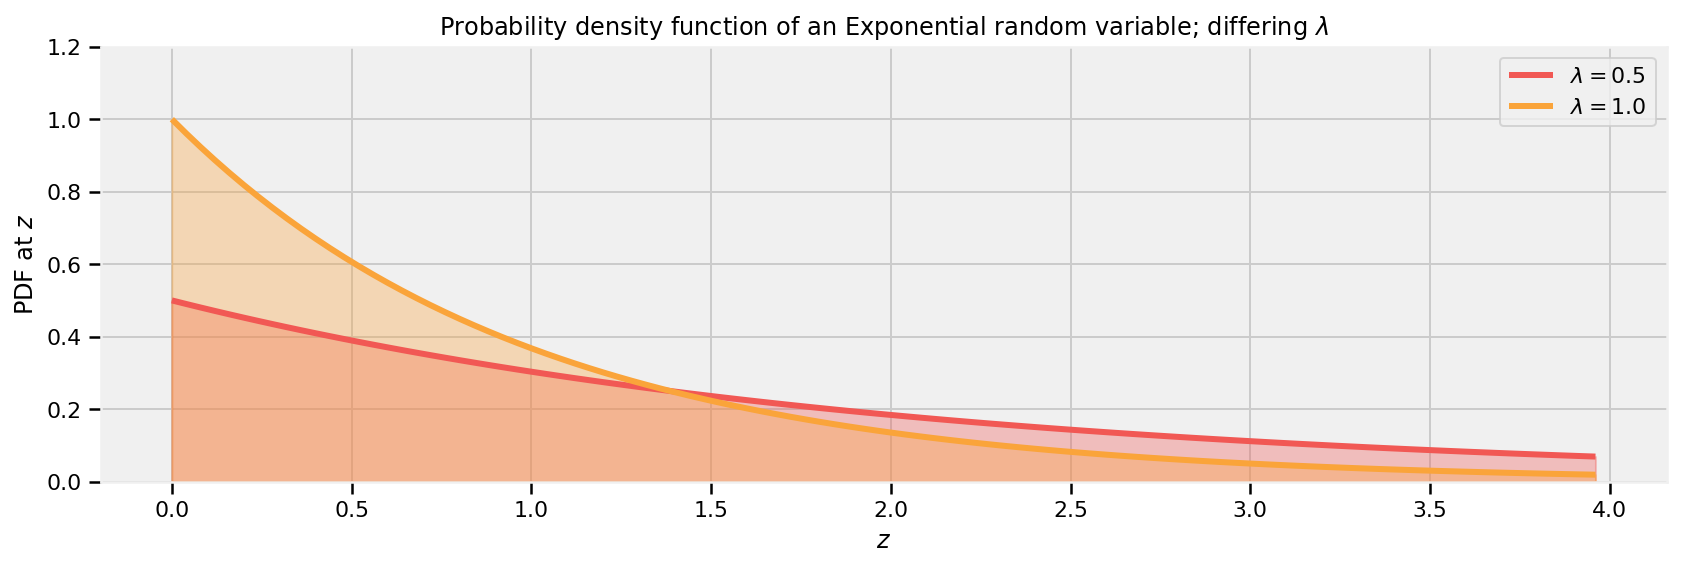

In [17]:


# Defining our Data and assumptions (use tf.linspace for continuous)
a = tf.range(start=0., limit=4., delta=0.04)
a = a[..., tf.newaxis]
lambdas = tf.constant([0.5, 1.])

# Now we use TFP to compute probabilities in a vectorized manner.
expo_pdf = tfd.Exponential(rate=lambdas).prob(a)

# Convert from TF to numpy
[
    a_,
    lambdas_,
    expo_pdf_,
] = evaluate([
    a,
    lambdas,
    expo_pdf,
])

# Visualizing our results
plt.figure(figsize=(12.5, 4))
for i in range(lambdas_.size):
    plt.plot(a_.T[0], expo_pdf_.T[[i]][0],
             lw=3, color=TFColor[i], label=r"$\lambda = %.1f$" % lambdas_[i])
    plt.fill_between(a_.T[0], expo_pdf_.T[[i]][0],
                         color=TFColor[i], alpha=.33)
plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title(r"Probability density function of an Exponential random variable; differing $\lambda$");



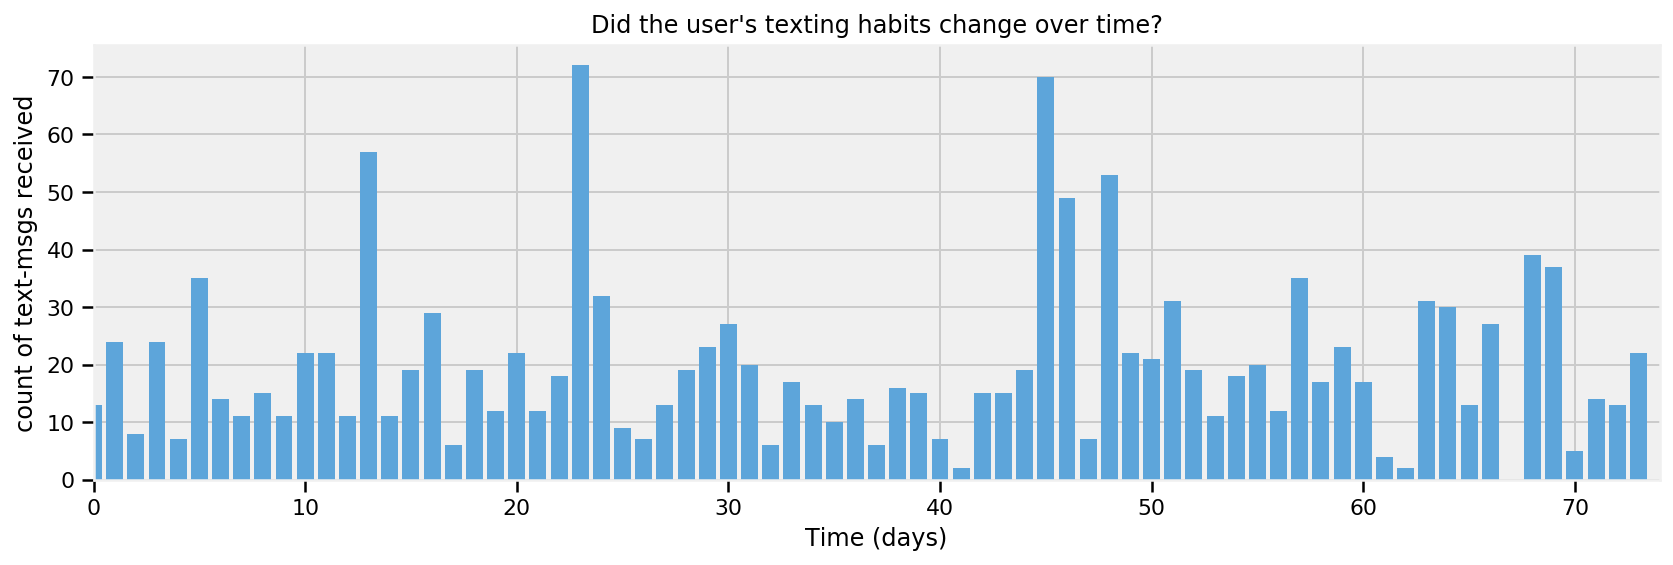

In [18]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0])

# Convert from TF to numpy.

[
    count_data_, 
    n_count_data_, 
    days_,
] = evaluate([
    count_data, 
    n_count_data,
    days,
])

# Visualizing the Results
    
plt.figure(figsize=(12.5, 4))
plt.bar(days_, count_data_, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data_[0]);